Loading handcrafted scaler and models...


Loading CNN model...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


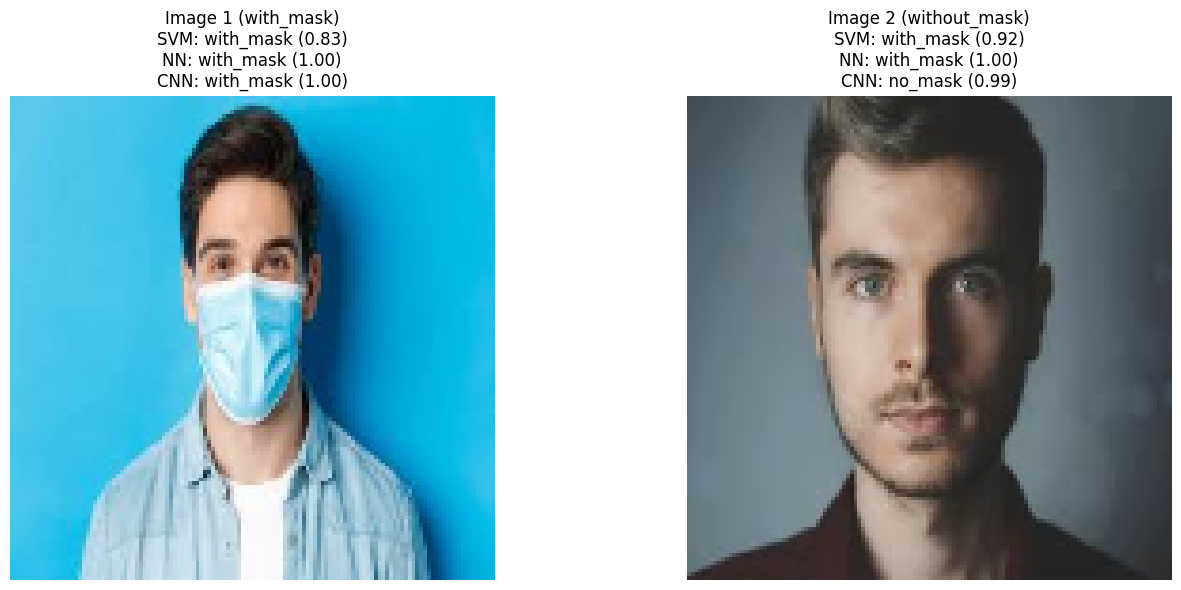

Image 1 Predictions:
  SVM: with_mask (Confidence: 0.83)
  NN (Handcrafted): with_mask (Confidence: 1.00)
  CNN: with_mask (Confidence: 1.00)

Image 2 Predictions:
  SVM: with_mask (Confidence: 0.92)
  NN (Handcrafted): with_mask (Confidence: 1.00)
  CNN: no_mask (Confidence: 0.99)


In [ ]:
import os
import cv2
import numpy as np
import joblib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image as keras_image
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern, hog

# ----------------------------
# Parameters and File Paths
# ----------------------------
IMG_SIZE = (128, 128)

# Handcrafted models/scaler paths
scaler_path = '../Models/scaler.pkl'
svm_model_path = '../Models/mask_svm_classifier.pkl'
nn_model_path = '../Models/mask_nn_classifier.h5'

# CNN model path (adjust as needed)
cnn_model_path = '../Models/cnn_classifcation.h5'

# Inference image paths
with_mask_path = '../Models/with_mask.jpeg'
without_mask_path = '../Models/without_mask.jpeg'

# ----------------------------
# Load Saved Models
# ----------------------------
print("Loading handcrafted scaler and models...")
scaler = joblib.load(scaler_path)
svm_classifier = joblib.load(svm_model_path)
nn_classifier = keras.models.load_model(nn_model_path)

print("Loading CNN model...")
cnn_model = keras.models.load_model(cnn_model_path)


# ----------------------------
# Handcrafted Feature Extraction
# ----------------------------
def extract_features(img):
    """
    Extracts handcrafted features from an image:
      1. Edge density via Canny edge detector.
      2. LBP texture histogram.
      3. HSV color histogram.
      4. HOG features.
      5. Skin segmentation ratio using YCbCr.
    Assumes input img is in BGR format and of size IMG_SIZE.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Edge Density
    edges = cv2.Canny(gray, 100, 200)
    edge_density = np.sum(edges) / (edges.size + 1e-6)

    # LBP Texture Histogram
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    hist_lbp, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 60), density=True)

    # HSV Color Histogram
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist_hsv = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist_hsv = cv2.normalize(hist_hsv, hist_hsv).flatten()

    # HOG Descriptor
    hog_features = hog(gray, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1))

    # Skin Segmentation (YCbCr)
    ycbcr = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    skin_mask = cv2.inRange(ycbcr, (0, 135, 85), (255, 180, 135))
    skin_ratio = np.sum(skin_mask == 0) / (skin_mask.size + 1e-6)

    # Concatenate features into one vector
    features = np.concatenate([[edge_density], hist_lbp, hist_hsv, hog_features, [skin_ratio]])
    return features


# ----------------------------
# Inference Functions
# ----------------------------
def infer_handcrafted(img, scaler, svm_clf, nn_clf):
    """
    Given an image (BGR, resized to IMG_SIZE), extract handcrafted features,
    normalize them, and predict using SVM and NN classifiers.
    Returns:
      (svm_label, svm_confidence, nn_label, nn_confidence)
    """
    feats = extract_features(img)
    feats = feats.reshape(1, -1)
    feats_norm = scaler.transform(feats)

    # SVM Prediction
    svm_prob = svm_clf.predict_proba(feats_norm)[0, 1]  # probability for positive class (assumed no_mask)
    svm_pred = svm_clf.predict(feats_norm)[0]
    svm_label = "no_mask" if svm_pred == 1 else "with_mask"
    # For consistency, if label is with_mask, confidence is 1 - prob
    if svm_label == "with_mask":
        svm_conf = 1 - svm_prob
    else:
        svm_conf = svm_prob

    # Neural Network Prediction (handcrafted NN)
    nn_prob = nn_clf.predict(feats_norm)[0][0]
    nn_pred = 1 if nn_prob > 0.5 else 0
    nn_label = "no_mask" if nn_pred == 1 else "with_mask"
    if nn_label == "with_mask":
        nn_conf = 1 - nn_prob
    else:
        nn_conf = nn_prob

    return svm_label, svm_conf, nn_label, nn_conf


def preprocess_for_cnn(img_path, target_size=IMG_SIZE):
    """
    Load image from path, resize, convert to array and scale to [0,1] for CNN.
    Returns preprocessed image ready for CNN inference.
    """
    img = keras_image.load_img(img_path, target_size=target_size)
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    return img_array


def infer_cnn(img_path, cnn_model):
    """
    Given an image path, preprocess it and run CNN inference.
    Returns (cnn_label, cnn_confidence)
    """
    processed_img = preprocess_for_cnn(img_path)
    cnn_prob = cnn_model.predict(processed_img)[0][0]
    cnn_pred = 1 if cnn_prob > 0.5 else 0
    cnn_label = "no_mask" if cnn_pred == 1 else "with_mask"
    cnn_conf = cnn_prob if cnn_label == "no_mask" else 1 - cnn_prob
    return cnn_label, cnn_conf


# ----------------------------
# Inference on Two Images & Plotting
# ----------------------------
def load_for_handcrafted(img_path):
    """
    Load image using OpenCV and resize to IMG_SIZE for handcrafted features.
    Note: OpenCV loads in BGR.
    """
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Image not found: {img_path}")
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError("Error loading image.")
    img_resized = cv2.resize(img, IMG_SIZE)
    return img_resized


# Process both images
img1_path = with_mask_path
img2_path = without_mask_path

# For handcrafted inference, use OpenCV loaded images
img1_hc = load_for_handcrafted(img1_path)
img2_hc = load_for_handcrafted(img2_path)

# Get predictions from handcrafted models
svm_label1, svm_conf1, nn_label1, nn_conf1 = infer_handcrafted(img1_hc, scaler, svm_classifier, nn_classifier)
svm_label2, svm_conf2, nn_label2, nn_conf2 = infer_handcrafted(img2_hc, scaler, svm_classifier, nn_classifier)

# Get CNN predictions (preprocess inside the function)
cnn_label1, cnn_conf1 = infer_cnn(img1_path, cnn_model)
cnn_label2, cnn_conf2 = infer_cnn(img2_path, cnn_model)

# For display, load images in RGB using OpenCV conversion
img1_rgb = cv2.cvtColor(img1_hc, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2_hc, cv2.COLOR_BGR2RGB)

# Prepare title text for each subplot
title1 = (f"Image 1 (with_mask)\n"
          f"SVM: {svm_label1} ({svm_conf1:.2f})\n"
          f"NN: {nn_label1} ({nn_conf1:.2f})\n"
          f"CNN: {cnn_label1} ({cnn_conf1:.2f})")
title2 = (f"Image 2 (without_mask)\n"
          f"SVM: {svm_label2} ({svm_conf2:.2f})\n"
          f"NN: {nn_label2} ({nn_conf2:.2f})\n"
          f"CNN: {cnn_label2} ({cnn_conf2:.2f})")

# Plot the two images side by side with titles
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(img1_rgb)
plt.title(title1, fontsize=12)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img2_rgb)
plt.title(title2, fontsize=12)
plt.axis("off")

plt.tight_layout()
plt.show()

# Also print the predictions
print("Image 1 Predictions:")
print(f"  SVM: {svm_label1} (Confidence: {svm_conf1:.2f})")
print(f"  NN (Handcrafted): {nn_label1} (Confidence: {nn_conf1:.2f})")
print(f"  CNN: {cnn_label1} (Confidence: {cnn_conf1:.2f})")
print("\nImage 2 Predictions:")
print(f"  SVM: {svm_label2} (Confidence: {svm_conf2:.2f})")
print(f"  NN (Handcrafted): {nn_label2} (Confidence: {nn_conf2:.2f})")
print(f"  CNN: {cnn_label2} (Confidence: {cnn_conf2:.2f})")